In [43]:
#!pip install python-rtmidi
#!pip install mido
import time
import rtmidi
import mido
from collections import deque
import matplotlib.pyplot as plt
import string

In [44]:
out=rtmidi.MidiOut()

In [45]:
ports_out= out.get_ports()

In [46]:
print(mido.get_output_names()) # To list the output ports

['LPK25', 'IAC_Driver python_to_logic', 'IAC_Driver logic_to_python', 'LPK25', 'IAC_Driver python_to_logic', 'IAC_Driver logic_to_python']


In [47]:
print(mido.get_input_names()) # To list the input ports

['LPK25', 'IAC_Driver python_to_logic', 'IAC_Driver logic_to_python', 'LPK25', 'IAC_Driver python_to_logic', 'IAC_Driver logic_to_python']


In [33]:
#inport = mido.open_input('IAC_Driver logic_to_python')
outport_ = mido.open_output('IAC_Driver python_to_logic')


In [8]:
outport_.name

'IAC_Driver python_to_logic'

In [50]:
#Generate Sound in GarageBand
middleC = 60
msg = mido.Message('note_on', note=middleC, velocity=64)
outport = mido.open_output(outport_.name)
outport.send(msg)

# On s'amuse 

In [ ]:
# une ptite note
middleC = 60
msg = mido.Message('note_on', note=middleC, velocity=64)
outport = mido.open_output(outport_.name)
outport.send(msg)

In [51]:
i = 24  # initialisation variable i pour note 24 = Do1
while i < 97:  # boucle notes à jouer dans la gamme Chromatique 24 à 96 / Do1 à Do7
    #print("Note =", i)  # affiche numéro de note jouée
    outport.send(mido.Message('note_on', note=i, velocity=100))
    time.sleep(0.1)  # durée d'environ 1/3 seconde
    outport.send(mido.Message('note_off', note=i))
    i = i +2  # incrémentation de l'index i (note jouée)

# Lecture d'un fichier MIDI (local ou distant)

In [57]:
root="/Users/WDescamps/Desktop/LeWagon/Music generation/Chords progression/"

In [59]:
lolilol="/Users/WDescamps/Desktop/LeWagon/Notebooks_Projets/MIDI_recorder-master/Recordings/rickroll.mid"

In [ ]:
# *** LECTURE d'un FICHIER MIDI ***
print("===== JOUE un Fichier MIDI... =====")

# ouvre un port OUT-MidO et le connecte à IN QS-M2 Qsynth/FluidSynth
port = mido.open_output(outport_.name)
 
# chemin absolu vers le fichier .mid, ici "blackvelvet.mid"
#mid = mido.MidiFile(root+'/SOUND7-Free-Midi-Chords/06 - F Major - D minor/4 Progression/Minor/hiphop style/D - i bVIIM bVIM bVIIM.mid')
test= mido.MidiFile(lolilol) # affiche chemin fichier Midi + son type + nb de pistes + nb de messages dans fichier
print("=>", test, "...\n... ...")
 
# calcul + affiche la durée de lecture du fichier Midi en h:m:s
print("=> Durée de lecture =", time.strftime('%Hh:%Mm:%Ss', time.gmtime(test.length)))
print("=> Lecture en cours...")
 
for msg in test.play():  # boucle de lecture du fichier Midi
    port.send(msg)      # envoi fichier Midi port MidO-OUT vers IN QS-M2 Qsynth/FS
    time.sleep(0.3)
 
port.close()  # ferme proprement le port Midi
print("=> Fichier MIDI lu... ARRÊT !")

===== JOUE un Fichier MIDI... =====
=> MidiFile(type=0, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='0013GIVE', time=0),
    MetaMessage('set_tempo', tempo=300000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('text', text='0013GIVE\x00\x00', time=0),
    Message('sysex', data=(126, 127, 9, 1), time=10),
    Message('sysex', data=(65, 16, 66, 18, 64, 0, 127, 0, 65), time=14),
    Message('sysex', data=(65, 16, 66, 18, 64, 1, 16, 2, 0, 1, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 23), time=24),
    Message('sysex', data=(65, 16, 66, 18, 64, 1, 51, 90, 50), time=24),
    Message('sysex', data=(65, 16, 66, 18, 64, 1, 58, 90, 43), time=40),
    Message('control_change', channel=1, control=121, value=0, time=212),
    Message('control_change', channel=2, control=121, value=0, time=4),
    Message('control_change', channel=3, control=121, value=0, time=4),
    

=> Durée de lecture = 00h:03m:36s
=> Lecture en cours...


# Lecture midi on disk, conversion en array, reconversion en midi

## Lecture midi on disk + conversion en array

In [52]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [55]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [56]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

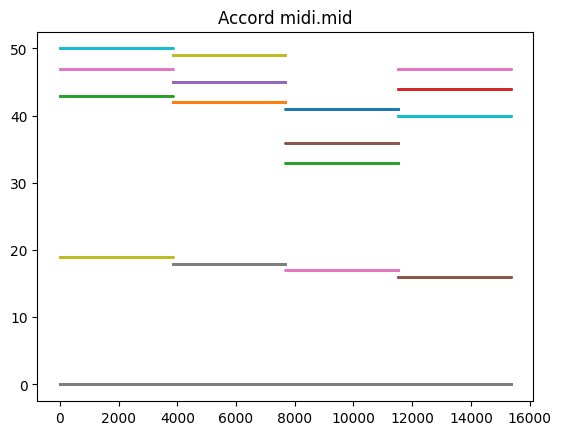

In [60]:
result_array = mid2arry(mid)

plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Accord midi.mid")
plt.show()

In [88]:
result_array.shape
#--> Probablement penser à convertir l'array en sparse

(15359, 88)

## Reconversion en midi

In [64]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [65]:
mid_new = arry2mid(result_array, 545455)
mid_new.save('mid_new.mid')

# Interaction clavier physique/code python

## Test basique

## Upgrade 